## Is it an afrobeat song?

In [1]:
%matplotlib inline

In [2]:
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm.auto import tqdm
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import soundfile
import requests
import spotipy
import torch

from fastai.vision.all import (
    CategoryBlock,
    DataBlock,
    ImageBlock,
    PILImage,
    RandomSplitter,
    Resize,
    get_image_files,
    accuracy,
    error_rate,
    parent_label,
    verify_images,
    vision_learner,
)
from fastcore.all import Path

import time
import io
import os


data_path = Path('../data/00/afrobeat_or_rock').resolve()
data_path.mkdir(parents=True, exist_ok=True)

## Step 1: Download spectrograms of afrobeat and rock songs

In [12]:
# connect to spotify
ccm = SpotifyClientCredentials(
    client_id=os.getenv('SPOTIFY_CLIENT_ID'),
    client_secret=os.getenv('SPOTIFY_CLIENT_SECRET')
)
sp = spotipy.Spotify(client_credentials_manager=ccm)


def save_spectrogram(url: str, track_uri: str, dest_dir: Path):

    # check if the spectrogram already exists
    save_path = dest_dir / f"{track_uri.split(':')[-1]}.png"
    if save_path.exists():
        return
    
    dest_dir.mkdir(parents=True, exist_ok=True)

    try:
        # fetch audio data
        response = requests.get(url)
        audio_data = io.BytesIO(response.content)
    except Exception as e:
        print(f"Error fetching audio data: {e}")
        return None

    # read audio data
    y, sr = soundfile.read(audio_data)
    if y.ndim > 1:
        y = y.mean(axis=1)  # Convert stereo to mono by averaging channels

    # compute spectrogram
    f, t, Sxx = signal.spectrogram(y, sr)

    # create spectrogram plot
    _, ax = plt.subplots(figsize=(5, 5))
    ax.pcolormesh(t, f, np.log(Sxx))
    ax.axis('off')  # Remove axes
    plt.tight_layout(pad=0)  # Remove any padding
    plt.margins(0,0)  # Remove margins
    ax.set_frame_on(False)  # Remove frame

    # save spectrogram
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()


def fetch_genre_tracks(genre: str, limit: int = 50):
    def fetch_tracks(album_uri: str):
        tracks = sp.album_tracks(album_uri)['items']
        for track in tracks:
            if track['preview_url'] and track['uri']:
                yield {'uri': track['uri'], 'url': track['preview_url']}

    if limit > 50:
        raise ValueError("Limit cannot be greater than 50")

    try:
        albums = sp.search(genre, type='album', limit=limit)['albums']['items']
    except Exception as e:
        print(f"Error fetching albums: {e}")
        return []

    album_uris = [album['uri'] for album in albums]

    dl_urls = []
    for album_uri in album_uris:
        dl_urls.extend(fetch_tracks(album_uri))
    
    return dl_urls


def get_random_sample(image_folder):
    image_files = get_image_files(image_folder)
    idx = np.random.randint(0, len(image_files))
    sample_image = image_files[idx]
    return PILImage.create(sample_image)

In [4]:
# get preview urls for afrobeat and rock songs
afrobeat_tracks = fetch_genre_tracks('afrobeat', limit=50)
rock_tracks = fetch_genre_tracks('rock', limit=50)

In [6]:
# save spectrograms
it = 0
for track in tqdm(afrobeat_tracks, desc='Downloading afrobeat spectrograms'):
    save_spectrogram(track['url'], track['uri'], data_path / 'afrobeat')
    it += 1
    if it % 50 == 0:
        time.sleep(2)

for track in tqdm(rock_tracks, desc='Downloading rock spectrograms'):
    save_spectrogram(track['url'], track['uri'], data_path / 'rock')
    it += 1
    if it % 50 == 0:
        time.sleep(2)

## Step 2: Train our model

In [4]:
failed = verify_images(get_image_files(data_path))
failed.map(Path.unlink)
len(failed)

0

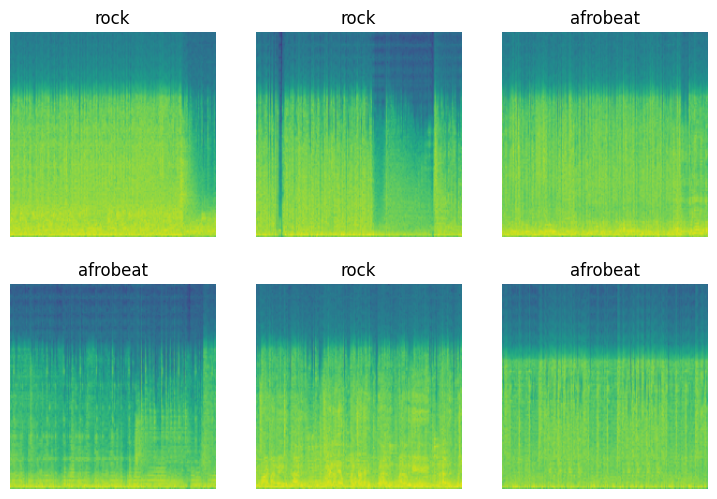

In [5]:
# create dataloaders to train the model with
# - imageblock to load images
# - categoryblock to load labels (afrobeat or rock)
# - random splitter to split the data into training and validation sets
# - parent_label to use the folder name as the label
# - resize to squish the images to 192x192

resnet_dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(data_path)

convnext_dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(224, method='squish')]
).dataloaders(data_path)

resnet_dls.show_batch(max_n=6)

In [6]:
from fastai.vision.all import resnet18

resnet_learn = vision_learner(resnet_dls, resnet18, metrics=[accuracy, error_rate])
resnet_learn.fine_tune(5)

del resnet18
torch.cuda.empty_cache()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.088975,0.704593,0.690608,0.309392,00:02


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.700640,0.624607,0.734807,0.265193,00:02
1,0.481997,0.395628,0.856354,0.143646,00:01
2,0.343912,0.463135,0.823204,0.176796,00:01
3,0.246263,0.488074,0.817680,0.182320,00:01
4,0.181898,0.496352,0.817680,0.182320,00:01


In [7]:
from fastai.vision.all import convnext_base

convnext_base_learn = vision_learner(convnext_dls, convnext_base, metrics=[accuracy, error_rate])
convnext_base_learn.fine_tune(5)

del convnext_base
torch.cuda.empty_cache()

/mnt/arrakis/study/fastai-course-p1-22/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/arrakis/study/fastai-course-p1-22/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.099689,0.748670,0.640884,0.359116,00:05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.933396,0.405984,0.812155,0.187845,00:09
1,0.836069,0.477850,0.751381,0.248619,00:09
2,0.797823,0.358722,0.839779,0.160221,00:09
3,0.725496,0.330552,0.883978,0.116022,00:09
4,0.690997,0.327826,0.878453,0.121547,00:09


In [8]:
from fastai.vision.all import convnext_large

# Reduce batch size to save memory
convnext_dls.batch_size = 16  # Adjust this value based on your GPU memory

convnext_large_learn = vision_learner(convnext_dls, convnext_large, metrics=[accuracy, error_rate])
convnext_large_learn.to_fp16()
convnext_large_learn.fine_tune(5)

# Clear memory after training
del convnext_large
torch.cuda.empty_cache()

/mnt/arrakis/study/fastai-course-p1-22/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/mnt/arrakis/study/fastai-course-p1-22/.venv/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/mnt/arrakis/study/fastai-course-p1-22/.venv/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instea

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.193836,0.512358,0.767956,0.232044,00:05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.874679,0.397669,0.801105,0.198895,00:06
1,0.852872,0.493085,0.762431,0.237569,00:07
2,0.796890,0.354558,0.850829,0.149171,00:07
3,0.744057,0.384316,0.845304,0.154696,00:07
4,0.684992,0.359780,0.856354,0.143646,00:07


## Step 3: Use our model (and build your own!)

In [16]:
img = get_random_sample(data_path / 'afrobeat')

for m in [resnet_learn, convnext_base_learn, convnext_large_learn]:
    is_afrobeat,_,probs = m.predict(img)
    print(f"This is a: {is_afrobeat}.")
    print(f"Probability it's afrobeat: {probs[0]:.4f}")

This is a: afrobeat.
Probability it's afrobeat: 0.9663


This is a: afrobeat.
Probability it's afrobeat: 0.9902


/mnt/arrakis/study/fastai-course-p1-22/.venv/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/mnt/arrakis/study/fastai-course-p1-22/.venv/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


This is a: afrobeat.
Probability it's afrobeat: 0.9837


In [17]:
img = get_random_sample(data_path / 'rock')

for m in [resnet_learn, convnext_base_learn, convnext_large_learn]:
    is_afrobeat,_,probs = m.predict(img)
    print(f"This is a: {is_afrobeat}.")
    print(f"Probability it's afrobeat: {probs[0]:.4f}")

This is a: rock.
Probability it's afrobeat: 0.0007


This is a: rock.
Probability it's afrobeat: 0.1308


/mnt/arrakis/study/fastai-course-p1-22/.venv/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/mnt/arrakis/study/fastai-course-p1-22/.venv/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


This is a: rock.
Probability it's afrobeat: 0.1453
